In [ ]:
import pandas as pd
from atom_pairs import encode_molecules
from map4 import MAP4Calculator
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm, tnrange
from glob import glob
import seaborn as sns

A simple function to create a Morgan fingerprint as a numpy array

In [ ]:
def fp_as_array(mol):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    arr = np.zeros((1,), int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

Build a dataframe from a SMILES file. 
1. Read the SMILES
2. Calculate a MAP4 fingerprint and put that into the dataframe
3. Calculate a Morgan fingerprint and put thta into the dataframe 

In [ ]:
def build_dataframe(input_file_name):
    df = pd.read_csv(input_file_name, header=None, sep=" ")
    df.columns = ["SMILES", "Name", "IC50"]
    m4_calc = MAP4Calculator(is_folded=True)
    df['mol'] = [Chem.MolFromSmiles(x) for x in df.SMILES]
    df['map4'] = [m4_calc.calculate(x) for x in df.mol]
    df['morgan'] = [fp_as_array(x) for x in df.mol]
    df['ap'] = encode_molecules(df.mol, 2048)
    return df

Benchmark a dataset.
1. Split into training and test sets using the sklearn defaults
2. Train and test an XGBoost regressor with MAP4 fingerprints and record the R<sup>2</sup>
3. Train and test an XGBoost regressor with Morgan fingerprints and record the R<sup>2</sup>  

Return lists of R<sup>2</sup> for MAP4 and Morgan

In [ ]:
def benchmark_dataset(df, name, cv_folds=5):
    map4_list = []
    morgan_list = []
    ap_list = []
    for i in tnrange(cv_folds, desc=name):
        train, test = train_test_split(df)
        map4_xgb = XGBRegressor()
        map4_xgb.fit(np.array([x for x in train.map4.values]), train.IC50)
        map4_pred = map4_xgb.predict(np.array([x for x in test.map4.values]))
        map4_r2 = r2_score(test.IC50, map4_pred)
        map4_list.append(map4_r2)

        morgan_xgb = XGBRegressor()
        morgan_xgb.fit(np.array([x for x in train.morgan.values]), train.IC50)
        morgan_pred = morgan_xgb.predict(np.array([x for x in test.morgan.values]))
        morgan_r2 = r2_score(test.IC50, morgan_pred)
        morgan_list.append(morgan_r2)

        ap_xgb = XGBRegressor()
        ap_xgb.fit(np.array([x for x in train.ap.values]), train.IC50)
        ap_pred = ap_xgb.predict(np.array([x for x in test.ap.values]))
        ap_r2 = r2_score(test.IC50, ap_pred)
        ap_list.append(ap_r2)

    return (np.array(map4_list), np.array(morgan_list), np.array(ap_list))

Run the bechmark on a set of files.  

In [ ]:
def run_benchmarks(file_spec):
    result_list = []
    for filename in glob(file_spec):
        df = build_dataframe(filename)
        name = filename.replace(".smi", "")
        map4_res, morgan_res, ap_res = benchmark_dataset(df, name)
        for map4, morgan, ap in zip(map4_res, morgan_res, ap_res):
            result_list.append([name, map4, morgan, ap])
    return result_list

Run the benchmark, on my MacBook Pro this took 21 minutes. 

In [ ]:
%time result_list = run_benchmarks("*.smi")

Put the results into a dataframe and write the dataframe to disk. 

In [8]:
result_df = pd.DataFrame(result_list,columns=["dataset","map4","morgan","ap"])
result_df.to_csv("map4_morgan_comparison.csv",index=False)

In case we come back to this later, uncomment the line below and start from there.

In [9]:
#result_df = pd.read_csv("map4_morgan_comparison.csv")

In [10]:
result_df.head()

,dataset,map4,morgan,ap
0,Dopamine,0.432281,0.602367,0.517664
1,Dopamine,0.324595,0.471026,0.494478
2,Dopamine,0.354020,0.466057,0.368317
3,Dopamine,0.421010,0.424442,0.494074
4,Dopamine,0.511953,0.599940,0.546152


Convert the dataframe to a format appropriate for a boxplot. The melt function combines the map4 and morgan columns into one column. 

In [11]:
melt_df = result_df.melt(id_vars="dataset")
melt_df.columns = ["dataset","method","r2"]
melt_df.head()

,dataset,method,r2
0,Dopamine,map4,0.432281
1,Dopamine,map4,0.324595
2,Dopamine,map4,0.354020
3,Dopamine,map4,0.421010
4,Dopamine,map4,0.511953


Make a boxplot of the results.

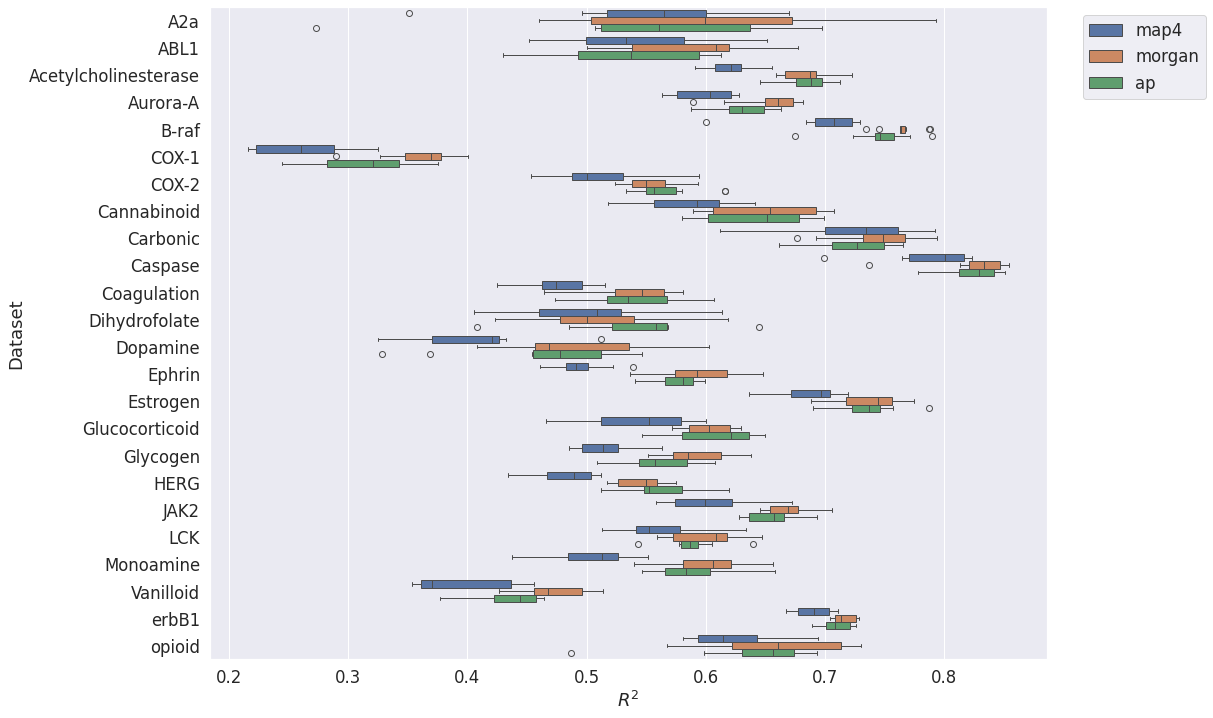

In [13]:
sns.set(rc={'figure.figsize': (15, 12)})
sns.set(font_scale=1.5)
ax = sns.boxplot(y="dataset",x="r2",hue="method",orient="h",data=melt_df,order=sorted(melt_df.dataset.unique()))
ax.set(ylabel="Dataset",xlabel="$R^2$")
_ = ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), ncol=1)

Calculate [Cohen's d](https://machinelearningmastery.com/effect-size-measures-in-python/) for the comparisons. 

In [14]:
cohen_list = []
for k,v in result_df.groupby("dataset"):
    delta = v.map4 - v.morgan
    cohen_list.append([k,np.mean(delta)/np.std(delta)])
cohen_df = pd.DataFrame(cohen_list,columns=["dataset","cohen_d"])

Make a plot of the effect is for each of the datasets. Lines are drawn at 
* Small Effect Size: d=0.20
* Medium Effect Size: d=0.50
* Large Effect Size: d=0.80

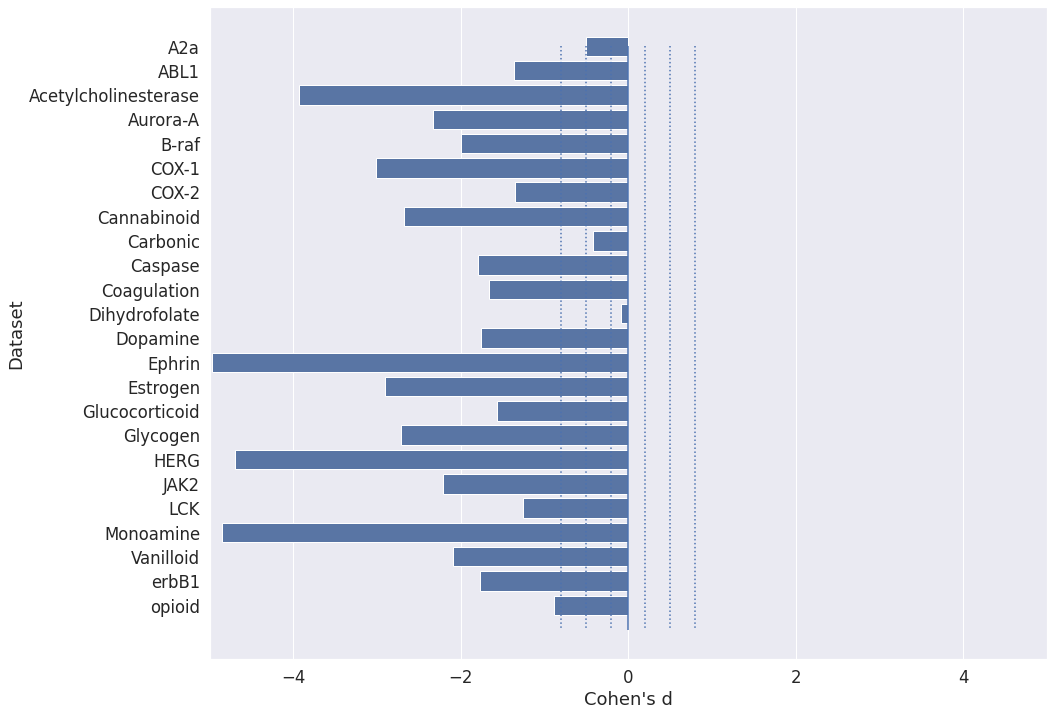

In [15]:
ax = sns.barplot(y="dataset",x="cohen_d",data=cohen_df,orient="h")
ax.set(ylabel="Dataset",xlabel="Cohen's d")
_ = ax.set(xlim=[-5,5])
ax.vlines(0,0,cohen_df.shape[0],linestyles="solid")
for i in [-0.8,-0.5,-0.2,0.2,0.5,0.8]:
    ax.vlines(i,0,cohen_df.shape[0],linestyles="dotted")

In [16]:
cohen_df.query("cohen_d < -0.8").shape

(21, 2)